# Getting started with Pytorch

Dan Drennan <danjdrennan@gmail.com>

26 May 2023

---

**NOTE**: This notebook was written to run in Google Colab. Pytorch is not installed in the local Dev Container or as a dependency in the `pyproject.toml` files.

## Overview

This notebook introduces the main parts of Pytorch, starting with basic tensor
operations, random number generation, implementing models through object
the object-oriented interface, and model optimization. Along the way it covers
train-validation-test splits and a few tricks for optimization. Links are shared
gratuitously throughout.

**NOTE**: This notebook is meant to run in Google Colab. If running locally, be
sure to install the following dependencies:

```yaml
python >= 3.10
pytorch >= 1.13
matplotlib >= 3.6
```

In [ ]:
# Imports (and most of the doc) follow the Google style guidelines for Python
# https://google.github.io/styleguide/pyguide.html
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn                # the neural network module
from torch.utils import data        # base classes for data loaders

## Tensor Basics

In Pytorch a tensor a multidimensional array data structure. Often there are
multiple ways to perform operations such as transposes or computing inverses.
The core data structure, a tensor, is implemented using lazy methods bound to
the instance objects, which makes one-liner calculations trivial to perform.

Before getting started, let's set a random seed to make the notebook run
repeatably. There are two ways to set a seed in Pytorch. The first is using a simple
manual seed call. The other is to create a `Generator` object. The latter is
preferred for distributed computing because the generators can be passed into
random functions to ensure that random numbers are generated consistently when
performing async operations.

In [ ]:
# This works
torch.manual_seed(0)

# This is preferred because you can pass generators to functions in distributed
# systems. More details: https://pytorch.org/docs/stable/generated/torch.Generator.html
gen = torch.Generator().manual_seed(0)

### Operations on Tensors

Now we can get started with some basic method chaining, then show how computations
on batched tensors works. To get started, we will create 1000 copies of a randomly
generated symmetric, positive definite matrix `a`. Making sure the matrix is
actually pd takes a little work, but the following shows one way to go about it.

In [ ]:
a = torch.randn(1000, 50, 50, generator=gen)

# We want to perturb the diagonal of `a` to make sure it is positive definite.
# We start by making an identity matrix of the same shape as any slice of `a`.
# Then we put a batch dimension on it and expand it to the same shape as `a`.
eyes = torch.eye(a.shape[-1]).unsqueeze(0).expand_as(a)

# Now finish the construction to make a positive definite matrix.
a = 0.5 * (a.mT @ a)
a += 10 * eyes

print(f"{a.shape = }")

a.shape = torch.Size([1000, 50, 50])


#### Data Types and Devices

A very first step is to either reset or query the device/datatype of a tensor.
By default, tensors are created as `float32` on the CPU. To change the device,
we can use the `cuda` method (when a device is available). Changing the data type
can be done by calls to `long`, `float`, or `double`. The following code shows
each of these.

We will use autograd later on, and so we will also inspect whether a tensor is
set to require gradient tracking.

In [ ]:
print(f"{a.dtype = }")
print(f"{a.device = }")
print(f"{a.requires_grad = }")

a.dtype = torch.float32
a.device = device(type='cpu')
a.requires_grad = False


In [ ]:
print("Data type conversions:")
print(f"{a.float().dtype = }")
print(f"{a.double().dtype = }")
print(f"{a.long().dtype = }")
print(f"{a.bool().dtype = }")
print('\n')

# Now casting to a GPU
print("Device conversions (only available if GPU is available):")
if torch.cuda.is_available():
    a = a.cuda()
    print(f"{a.device = }")
    a = a.cpu()
    print(f"{a.device = }")

Data type conversions:
a.float().dtype = torch.float32
a.double().dtype = torch.float64
a.long().dtype = torch.int64
a.bool().dtype = torch.bool


Device conversions (only available if GPU is available):
a.device = device(type='cuda', index=0)
a.device = device(type='cpu')


#### Indexing, Slicing, and Dimension Swapping

A first step is to look at indexing and querying dimensions. The next block shows
how to get the dimension of the tensor and various ways to slice through it.
Note the dimension of a tensor is the number of axes we can index over.

The main methods to look at here are `dim`, which gives the dimension the
equivalent `size`/`shape` methods, which gives the size of the tensor along each
dimension; and the `numel` method, which gives the number of elements in the
tensor.

In [ ]:
print(f"{a.dim() = }")
print(f"{a.size() = }")
print(f"{a.shape = }")
print(f"{a.numel() = }")

a.dim() = 3
a.size() = torch.Size([1000, 50, 50])
a.shape = torch.Size([1000, 50, 50])
a.numel() = 2500000


Next we look at various ways to slice a tensor. Some would argue a best practice
is to slice using the `:` notation at the top of each printed block. This is not
a universal best practice, though, and there are some nicer ways to slice tensors
that are shown as alternatives. I am partial to the `...` notation when indexing
into the last dimension of a tensor.

One note is that this slicing drops the sliced dimension.

In [ ]:
# The following are equivalent
print(f"{a[0, :, :].shape = }")
print(f"{a[0, ...].shape = }")
print(f"{a[0].shape = }")
print('\n')

# The following are equivalent
print(f"{a[:, :, 0].shape = }")
print(f"{a[..., 0].shape = }")
print("\n")

# The following are equivalent
print(f"{a[:, 0, :].shape = }")
print(f"{a[:, 0].shape = }")
print(f"{a[..., 0, :].shape = }")

a[0, :, :].shape = torch.Size([50, 50])
a[0, ...].shape = torch.Size([50, 50])
a[0].shape = torch.Size([50, 50])


a[:, :, 0].shape = torch.Size([1000, 50])
a[..., 0].shape = torch.Size([1000, 50])


a[:, 0, :].shape = torch.Size([1000, 50])
a[:, 0].shape = torch.Size([1000, 50])
a[..., 0, :].shape = torch.Size([1000, 50])


Other indexing that works as expected is slicing subsets of a dimension as follows.

In [ ]:
print(f"{a[0, 0, 0] = :.4f}")

# The following are equivalent ways of selecting the first 5 elements of the
# last dimension, keeping all of the first two dimensions. Similar slicing can
# be done for other dimensions or over multiple dimensions.
a[..., :5].shape, a[:, :, :5].shape, a[:, :, 0:5].shape, a[..., 0:5:1].shape

a[0, 0, 0] = 40.3990


(torch.Size([1000, 50, 5]),
 torch.Size([1000, 50, 5]),
 torch.Size([1000, 50, 5]),
 torch.Size([1000, 50, 5]))

Occassionally we may want to swap or permute the axes of a tensor. This came up
in my work recently when I wanted to move the last dimension into the first axis
while keeping all others in the same place. The `permute` and `swapaxes` methods
are useful for this. The `permute` method takes a list of integers that specify
the new order of the axes, and requires that we specify every dimension in the
call. The `swapaxes` method takes two integers and swaps the axes at those two
positions.

In [ ]:
print(f"{a.shape = }")
print(f"{a.swapaxes(0, 1).shape = }")
print(f"{a.permute(1, 0, 2).shape = }")

a.shape = torch.Size([1000, 50, 50])
a.swapaxes(0, 1).shape = torch.Size([50, 1000, 50])
a.permute(1, 0, 2).shape = torch.Size([50, 1000, 50])


#### Method Chaining

Now let's look at some typical method chaining operations. First we can exponentiate
the matrices element-wise and check that all the entries are nonnegative. As
this block shows, there are several equivalent ways of doing this, with varying
degrees of method chaining employed. To be perfectly clear about the operation
we're doing in the next cell, the long-form computation would look like the
following:

```python
exp_a = torch.exp(a)
exp_a_geq_0 = exp_a >= 0
all_exp_a_geq_0 = torch.all(exp_a_geq_0)
```

The downside to making the computation in this way is that we'd create several
copies of a possibly large matrix, which is a collosal waste of memory! So let's
look at more efficient one-liners. We use successively more and more method
chaining in the following lines:

In [ ]:
print(f"{torch.all(torch.exp(a) >= 0) = }")
print(f"{torch.all(a.exp() >= 0) = }")
print(f"{a.exp().ge(0).all() = }")

torch.all(torch.exp(a) >= 0) = tensor(True)
torch.all(a.exp() >= 0) = tensor(True)
a.exp().ge(0).all() = tensor(True)


To get a better sense of what operations are available for method chains, the
following code provides a non-exhaustive list of operations that can be called.

In [ ]:
(
    # Method chaining is a great way to write readable code.
    # The (...) syntax is crucial to make this syntax work.
    a.exp()         # element-wise exponential
    .log()          # element-wise logarithm
    .pow(2)         # element-wise power
    .square()       # element-wise square
    .pow(0.5)       # element-wise square root
    .sqrt()         # element-wise square root
    .rsqrt()        # element-wise reciprocal square root
    .reciprocal()   # element-wise reciprocal
    .inverse()      # matrix inversion over the last two dimensions
    .neg()          # element-wise negation
    .add(5)         # element-wise addition
    .sub(5)         # element-wise subtraction
    .mul(5)         # element-wise multiplication
    .div(5)         # element-wise division
    .matmul(a)      # matrix multiplication over the last two dimensions
    .isnan()        # element-wise check for NaN values
).any()             # check if any element is True

tensor(False)

#### Batched Linear Algebra Operations

Recall this matrix `a` is 1000 samples of a 50x50 pd matrix. The next cell
demonstrates how we can call desirable matrix operations on batched matrices.
An annoying aspect of the torch functions is that `eig` returns the eigenvalues
as a complex type in all cases, so we need to cast them to real numbers if using
this method. The operations are quite fast though, and the parallelization is
awfully convenient.

In [ ]:
# SVD, Cholesky, and Eigen decompositions
u, s, v = torch.linalg.svd(a)
print(f"{u.shape = }")
print(f"{s.shape = }")
print(f"{v.shape = }")
print('\n')

eigvals, eigvecs = torch.linalg.eig(a)
print(f"{eigvals.shape = }")
print(f"{eigvecs.shape = }")
print('\n')

chol = torch.linalg.cholesky(a)
print(f"{chol.shape = }")

u.shape = torch.Size([1000, 50, 50])
s.shape = torch.Size([1000, 50])
v.shape = torch.Size([1000, 50, 50])


eigvals.shape = torch.Size([1000, 50])
eigvecs.shape = torch.Size([1000, 50, 50])


chol.shape = torch.Size([1000, 50, 50])


This is slightly contrived but we can now use summary statistics over the
batch dimension to plot images, as shown next.

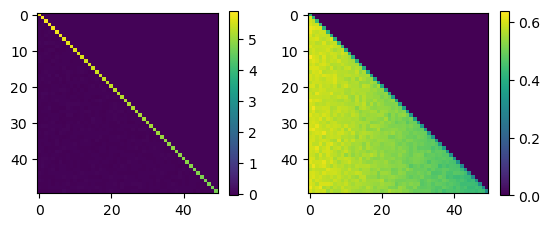

In [ ]:
fig, ax = plt.subplots(1, 2)
im = ax[0].imshow(chol.mean(0))
plt.colorbar(im, ax=ax[0], shrink=0.5)
im = ax[1].imshow(chol.std(0))
plt.colorbar(im, ax=ax[1], shrink=0.5)
plt.show()

### Regression Example

To elucidate the point about how tensors are working, we can start by solving
the same regression task 1000 times in parallel. Before doing this, let's generate
a data matrix and look at some methods for querying tensors.

The dimension of a tensor is the number of axes in the object. For example, the
3 dimensional tensor generated in the next cell has 1000 batches, 30 samples per
batch, and 3 input features. We use the `randn` function to generate independent
random noise in each dimension. Other useful random functions are the `rand`
function for sampling from a uniform distribution, and the `randint` function
for sampling from a discrete uniform distribution. Also there is the `randperm`
function for generating a random permutation of integers, typically to permute
the rows of a tensor.

In [ ]:
# Create 100 instances of data to multiply with the true parameters. The shape
# here is (b batches, n samples, p input dimensions). Note how we pass the gen
# object created before to this randn function.
x = torch.randn(1000, 30, 3, generator=gen)

# We can get a lot of information about the tensor from the shape, dim, and size
# methods. See below.
print(f'x shape: {x.shape}')
print(f'x dim: {x.dim()}')
print(f'x size: {x.size()};\t(an alias for shape)')

x shape: torch.Size([1000, 30, 3])
x dim: 3
x size: torch.Size([1000, 30, 3]);	(an alias for shape)


Now let's finish constructing the data. The parameters can be in $\mathbb{R}^{3}$,
with no additional dimensions included. However, it is preferable for reasons we
will see later to make explicit that `_b` is a $3 \times 1$ tensor.

In [ ]:
_b = torch.tensor([2., 1., 0.5])
print(f"Note the shape of this operation: {(x @ _b).shape}")

# Calculate the mean first
y = x @ _b.unsqueeze(-1)

# Now put noise on the data
y += 0.1 * torch.randn_like(y)

Note the shape of this operation: torch.Size([1000, 30])


In [ ]:
print('Data shapes:')
print(f'{x.shape = }')
print(f'{y.shape = }')

Data shapes:
x.shape = torch.Size([1000, 30, 3])
y.shape = torch.Size([1000, 30, 1])


Now we have a dataset to compute with and we would like to solve the regression
problems. Using OLS is the preferred approach, but it requires us to transpose
this tensor `x` which has four dimensions. How can this be done? The key is to
use one of the following transpose operations:

In [ ]:
print(f"Original tensor shape: {x.shape = }\n")
print(f"{x.transpose(-1, -2).shape = }")
# More simply
print(f"{x.mT.shape = }")

# Now compute the requisite quadratic forms in parallel
s_hat = x.mT @ x
print(f"{s_hat.shape = }")

xt_y = x.mT @ y
print(f"{xt_y.shape = }")

Original tensor shape: x.shape = torch.Size([1000, 30, 3])

x.transpose(-1, -2).shape = torch.Size([1000, 3, 30])
x.mT.shape = torch.Size([1000, 3, 30])
s_hat.shape = torch.Size([1000, 3, 3])
xt_y.shape = torch.Size([1000, 3, 1])


Notice the effect of shaping the tensors the way we did. Because `x` and `y` are
both 3D, we can use the `mT` (matrix transpose) operator, and pytorch recognizes
the first dimension as a batching dimension for all matrix operations. This is
incredibly useful, although it takes some adapting to recognize these operations
can work this way.

Now we can move on to estimating $b$ in the 100 cases we have generated.

In [ ]:
b = s_hat.inverse() @ xt_y

print(f"{b.shape = }")

# We no longer need the last dimension, so we can squeeze it off the tensor
b = b.squeeze()

b.shape = torch.Size([1000, 3, 1])


Now we can make a plot of the parameter estimates. The following code is a good
sample for plotting with subplots using a common legend. Note the `fig.legend`
method allows us to use a global legend for all subplots, and provides arguments
for placing it in the figure.

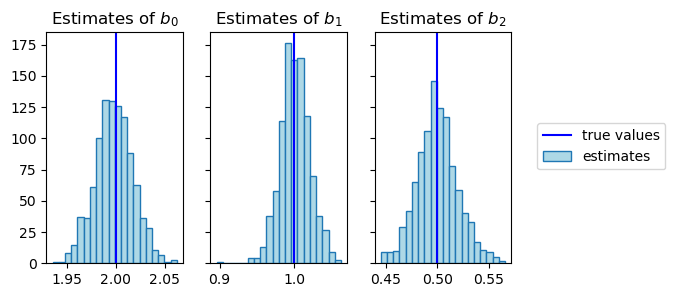

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (6, 3), sharey=True)
for i in range(3):
    ax[i].hist(b[..., i], bins=20, edgecolor='C0', facecolor='lightblue')
    ax[i].axvline(_b[i], c='b', ls='-')
    ax[i].set_title("Estimates of $b_{}$".format(i))

fig.legend(['true values', 'estimates'], loc="center", ncol=1, bbox_to_anchor=(1.05, 0.5))
plt.show()

We hadn't covered it yet, but we can average over the batching dimension of `b`
now to get good parameter estimates.

In [ ]:
print(f"estimates of b averaged over batch dim: {b.mean(0)}")
print(f"true values of b: {_b}")

estimates of b averaged over batch dim: tensor([1.9980, 1.0008, 0.5000])
true values of b: tensor([2.0000, 1.0000, 0.5000])


### Automatic Differentiation

One of the appealing aspects of using an ML library like Pytorch, even for non-ML
projects, is the availability of automatic differentiation (AD). This is a powerful
tool for computing gradients of functions, and is the basis for pretty much all
of ML. Helpful papers on the topic include the following:

- [Autograd: Effortless Gradients in Numpy](https://indico.ijclab.in2p3.fr/event/2914/contributions/6483/subcontributions/180/attachments/6060/7185/automl-short.pdf)
- [Automatic Differentiation in Pytorch](https://openreview.net/forum?id=BJJsrmfCZ)
- [Automatic Differentiation in Machine Learning: a Survey](https://arxiv.org/abs/1502.05767) (This is a comprehensive review)
- [Automatic Differentiation Variational Inference](https://arxiv.org/abs/1603.00788)

Andrej Karpathy (Stanford PhD in ML, formerly the head of AI at Tesla,
and currently at OpenAI) demonstrated how to implement this from scratch on his
YouTube channel: https://youtu.be/VMj-3S1tku0. An interested reader may find that
this helpful to review.

In the next two blocks we will look at autograd in action. First we will compute
gradients and derivatives of a simple polynomial to see how to use this. Next we
will look at how to compute Jacobians and Hessians of functions. This is rarely
needed in a standard deep learning workflow, but it may be useful to see.

#### Standard Autograd

AD is one of the most desirable features of Pytorch. It allows us to build up
complex computational graphs and then compute gradients of the output with respect
to the inputs without explicitly computing the derivatives of functions ourselves.
The basic idea behind autograd is the chain rule of calculus,
$$
    \frac{dz}{dx} = \frac{dz}{dy}\frac{dy}{dx},
$$
which is applied recursively to compute the gradient of a function with respect
to its parameters and inputs.

A familiar problem is to compute the position function in a falling body problem.
Specifically, we have the position function
$$
    s(t) = 20 + 10 t -5 t^2
$$
and its derivative $s'(t) = -10 t + 10$. At $t = (0, 0.2, 0.4, 0.6, 0.8, 1.0)$,
one can check the derivative is $s'(t) = (10, 8, 6, 4, 2, 0)$.

When we construct the tensors below, we will pass the `requires_grad=True`
flag to the constructors. This will tell Pytorch to track the gradients of the
tensors with respect to the parameters. This causes a lot of bookkeeping to be
done behind the scenes. More on this from the Pytorch developer podcast:
https://open.spotify.com/episode/63OCX7hrpYYwWBx0imfu52?si=435e2de1da984f21.


In [ ]:
t = torch.linspace(0, 1, 6, requires_grad=True)
beta = torch.tensor([20., 10., -5.])

def pos(t: torch.Tensor, beta: torch.Tensor) -> torch.Tensor:
    """The position function for a falling body problem."""
    return beta[0] + beta[1] * t + beta[2] * t**2

# Make a computation for s
s = pos(t, beta)

# Note here the gradients of these tensors are None
print(f"{beta.grad = }")
print(f"{t.grad = }")

beta.grad = None
t.grad = None


The last cell built up a computational graph between the inputs $t$, polynomial
parameters $\beta$, and the output $s$. To get gradients from the output, we need
to reduce $s$ from a tensor to a scalar. Once we reduce $s$ to a scalar we can
call `backward` on it to compute the gradients of the parameters $\beta$ as well
as the derivative at the inputs $t$. Typically the summary function will be a
loss function (in the `torch.nn` namespace), but in this case any summary
function will do. Here we just compute a sum
$$
    T = \sum_{i=1}^{6} s(t_i)
$$
and compute the derivatives of $T$ with respect to $\beta$ and $t$. After
reducing the outputs to a scalar, we can invoke the `backward` method to compute
the gradients. The gradients are stored in the `.grad` attribute of the tensors.

In [ ]:
# Reduce the function
ad_loss = s.sum()
# Compute the gradients
ad_loss.backward()

Now we can inspect the gradients of the input tensor $t$ to get the derivatives
$s'(t)$.

In [ ]:
print(f"Derivative of s wrt t: {t.grad = }")

Derivative of s wrt t: t.grad = tensor([10.,  8.,  6.,  4.,  2.,  0.])


Note the function $s$ is a so-called leaf node (end of the graph), and
the gradients for this tensor are not stored. Trying to get this gradient through
the `.grad` attribute will return a `UserWarning`, which includes instructions
on how to retain this gradient if you need it for some reason (you shouldn't in
general).

In [ ]:
s.grad

/tmp/ipykernel_9660/2235496752.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/build/aten/src/ATen/core/TensorBody.h:486.)
  s.grad


Above we computed the function derivatives with respect to $t$ as an illustrative
example. However, this is an atypical application of autograd. For ML applications
we are actually interested in the gradient of the function's parameters, in this
case $\beta = (\beta_0, \beta_1, \beta_2) = (20, 10, -5)$. This gradient is
$$
    \nabla_\beta\ s(t) =
    \nabla_\beta\ (\beta_0 + \beta_1 t + \beta_2 t^2) =
    (1, t, t^2),
$$
although it is actually computed with respect to the sum $T$. Hence we instead
get
$$
    \nabla_\beta T =
    \sum_{i=1}^{6} \left( 1, t_i, t_i^2\right) =
    \left( 6, 3, 2.2 \right).
$$
In fact this gradient was computed above, but we didn't inspect it. Now we see it
in the next cell.

In [ ]:
print(f"Gradient {beta.grad = }")

Gradient beta.grad = None


#### Other Gradient Functions

The `torch.autograd` namespace has a number of other functions for computing
gradients. In some applications (e.g., normalizing flows, variational inference,
etc.) we need to compute the Jacobian of a function. In other applications we
need to compute the Hessian of a function; examples are variational inference,
Newton-Raphson methods, and for Laplace approximations to a posterior distribution.
The following cells show how to compute these. References in the Pytorch
documentation are
- [torch.autograd.grad](https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad)
- [torch.autograd.functional.jacobian](https://pytorch.org/docs/stable/autograd.html#torch.autograd.functional.jacobian)
- [torch.autograd.functional.hessian](https://pytorch.org/docs/stable/autograd.html#torch.autograd.functional.hessian)


**Computing the Jacobian**

The Jacobian of a function $f: \mathbb{R}^n \to \mathbb{R}^m$ is the matrix of
partial derivatives
$$
    J_{ij} = \frac{\partial f_i}{\partial x_j}, \quad i=1,\dots, m, j=1, \dots, n.
$$
As before, the typical interest for this computation is with respect to the parameters
of the function, not the inputs. In the example below we compute the Jacobian of
the polynomial function $s(t)$ with respect to the parameters $\beta$. Setting
`create_graph=False` indicates to Pytorch that we do not need to build a
computational graph for the Jacobian. This is the typical case, as the Jacobian
is usually used as an ancillary computation for optimization.

In [ ]:
jac = torch.autograd.functional.jacobian(
    lambda b: pos(t=t, beta=b).sum(), beta, create_graph=False
)

print(jac)

tensor([6.0000, 3.0000, 2.2000])


The common application of a Hessian is either to compute the curvature of a
function or to compute the covariance of the parameters of a model. In both
cases, we are computing a quadratic form. In an explicit Newton-Raphson method,
we would use the inverse Hessian to normalize the gradient. This is related to
the approach taken in MCMC sampling using Laplace approximations as well, which
would be the other main application for this function.

In [ ]:
hess = torch.autograd.functional.hessian(
    lambda b: pos(t=t, beta=b).square().sum(), beta, create_graph=False
)

print(hess)

tensor([[12.0000,  6.0000,  4.4000],
        [ 6.0000,  4.4000,  3.6000],
        [ 4.4000,  3.6000,  3.1328]])


## Building Neural Networks

Now we turn to building a neural network. Neural networks and other types of
models are constructed using the `nn.Module` class. This class is the parent
class for all neural network models in Pytorch. Inheriting from the model means
at least defining an `__init__` constructor and a `forward` method. The Pytorch
module calls `forward` methods in the `__call__` function with additional buffers
and checks.

The constructor is where we define the layers of the network and parameters. The
`forward` method is where we define the computation that happens in the network.
We inherit several methods from the parent class by calling `super().__init__()`
in the constructor. For this Pytorch has good YouTube tutorials; cf.
https://youtu.be/OSqIP-mOWOI.

The remainder of this section is divided into three sections
   - Defining helper functions and data structures
   - Defining a linear regression model in Pytorch
   - Defining deep networks in Pytorch

For each modeling part we will use the same regression data set simulated
previously.

### Defining Helper Functions and Classes

It is often helpful to define helper functions and classes to reduce boilerplate
code, which we in this block to emphasize focus on the neural networks in subsequent
sections. This code can be skipped in the first reading and studied in more detail
later. For now, just know the next blocks are defining:
  - defining a `RegressionData` class which inherits from `torch.utils.data.Dataset`
  - defining a `TrackedLossFunctions` dataclass for storing loss functions
  - defining helper functions for model optimization
  - plotters to visualize the loss functions

In [ ]:
# Data classes: One for model data and one for tracked loss functions
class RegressionData(data.Dataset):
    """A data abstraction layer for use when training on our regression data.

    These are suitable abstraction layers to use with Pytorch. A more lightweight
    alternative would be to use a `NamedTuple` from the `typing` module or a
    `dataclass` from the `dataclasses` module. The reason to use the Pytorch
    `Dataset` class is that it is compatible with the `DataLoader` class, which
    simplifies minibatch processing of the data.

    Aside from the `__init__` method which constructs an abstraction of our data,
    we must implement the `__len__` and `__getitem__` methods. The `__len__`
    method allows us to call `len(dataset)` and get the number of samples in the
    dataset. The `__getitem__` method allows us to index the dataset like a list
    or tuple, e.g., `dataset[0]` will return the first sample in the dataset.

    Attributes:
        x (torch.Tensor): The input data.
        y (torch.Tensor): The output data.
    """

    def __init__(self, x: torch.Tensor, y: torch.Tensor) -> None:
        """Initialize the dataset."""
        super().__init__()
        self.x = x
        self.y = y

    def __len__(self) -> int:
        """Return the number of samples in the dataset."""
        return self.x.shape[0]

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Return a sample from the dataset."""
        return self.x[idx], self.y[idx]

@dataclass
class TrackedLossFunctions:
    """A dataclass to hold the output of a model."""
    train_loss: torch.Tensor
    val_loss: torch.Tensor

    def __len__(self) -> int:
        """Return the number of epochs."""
        return self.train_loss.shape[0]


In [ ]:
# Optimization functions: Two closures to use within the `fit_map` function
def train_loop(dataloader, model, loss_fn, optimizer, scheduler) -> float:
    """A closure around the training loop used in `fit_map`."""
    size = len(dataloader.dataset)
    train_loss = 0.
    for _, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    return train_loss / size

def test_loop(dataloader, model, loss_fn) -> float:
    """A closure around the validation loop in `fit_map`."""
    size = len(dataloader.dataset)
    test_loss = 0.
    with torch.no_grad():
        for _, (x, y) in enumerate(dataloader):
            y_pred = model(x)
            test_loss += loss_fn(y_pred, y).item()
    test_loss /= size
    return test_loss


def fit_model(
        train_data: RegressionData | data.Subset,
        validation_data: RegressionData | data.Subset,
        model: nn.Module,
        /,
        learn_rate: float = 1e-3,
        nsteps: int = 1000,
        batch_size: int = 64,
        generator: None | torch.Generator = None
    ) -> TrackedLossFunctions:
    """A helper function to fit our models.

    This function documents by way of an example many of the tricks one
    would want to use for model training, including use of
        - minibatching
        - learning rate schedulers
        - and train/test splitting/evaluation.
    Where relevant, references to documentation are provided.

    Args:
        train_data (RegressionData | data.Subset): The training data.
        test_data (RegressionData | data.Subset): The test/validation_data to
            compare the model with.
        model (nn.Module): The model to train. Any subclass of nn.Module will
            work here.
        learn_rate (float): The learning rate to use for the optimizer.
        nsteps (int): The number of steps (epochs) to train for.
        batch_size (int): The batch size to use for minibatching.
        generator (None | torch.Generator): A random number generator to use
            for minibatching. If None, no generator is used.

    Returns:
        tuple[torch.Tensor, torch.Tensor]: training and test/validation loss.

    Notes:
        Basic optimization is covered in the PyTorch tutorials:
        https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

        See PEP 570 for the use of the `/` in the function signature:
        https://peps.python.org/pep-0570/

        See Google Style Guide for general documentation tips and more:
        https://google.github.io/styleguide/pyguide.html
    """

    # `torch.nn.Modules` have `train` and `eval` modes. Start this off by making
    # sure we are in train mode. It's a good idea to start any function like this
    # off with such a command.
    model.train()

    # Data preprocessing: We want to use minibatch gradient descent here, so we
    # start by reshaping the data into the required batches.
    train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=generator)
    val_loader = data.DataLoader(validation_data, batch_size=batch_size, shuffle=True, generator=generator)

    # Next, we need an optimizer. The Adam optimizer is a good choice for most
    # problems, and is the one used here. We will pass the `lr` to it. Other
    # optimizers are available in the `torch.optim` module.
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    # A learning rate scheduler is a function that decreases the learning rate
    # of the optimizer over time. In theory the model is converging on the true
    # parameters as the number of steps increases, so we want to decrease the
    # learning rate to avoid overshooting the minimum. This is an
    # exploration/exploitation problem, where we want to explore the space
    # initially, but exploit the knowledge we have gained as we get closer to
    # the minimum. The `torch.optim.lr_scheduler` module contains several classes
    # for this purpose. Here we use the `torch.optim.lr_scheduler.ExponentialLR`.
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, verbose=False, gamma=0.99)

    # The final ingredient is a loss function. Pytorch defines loss functions
    # for us, so it is preferable to use those. Here we use the mean squared
    # error.
    mse_loss = torch.nn.MSELoss()

    # We're ready to train. We'll store the training and test losses in respective
    # tensors. The inside of this training loop is now quite simple due to the
    # closures we defined above.
    training_loss = torch.empty(nsteps)
    val_loss = torch.empty(nsteps)

    for epoch in range(nsteps):
        training_loss[epoch] = train_loop(train_loader, model, mse_loss, optimizer, scheduler)
        val_loss[epoch] = test_loop(val_loader, model, mse_loss)

    # Switch the model back into `eval` mode before exiting.
    model.eval()

    return TrackedLossFunctions(training_loss, val_loss)

In [ ]:
# Plot function
def plot_loss(
    tracked_loss: TrackedLossFunctions, ax: plt.Axes | None = None, use_inset=True
) -> plt.Axes:
    """A helper function for plotting the loss.

    Args:
        tracked_loss (TrackedLossFunctions): The loss functions to plot.
        ax (plt.Axes | None): The axes to plot on. If None, a new figure is
            created.
        use_inset (bool): Whether to use an inset plot for the last 1/5 of the
            data. Defaults to True.
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    ax.plot(tracked_loss.train_loss, label="train loss")
    ax.plot(tracked_loss.val_loss, label="test loss")
    ax.set_title("Training a deep neural network (100 hidden layers)")
    ax.set_xlabel("epoch")
    ax.set_ylabel("training loss")

    if use_inset:
        n = len(tracked_loss)
        start_idx = 4 * n // 5
        inset_ax = ax.inset_axes([0.5, 0.5, 0.45, 0.45])
        inset_ax.plot(torch.arange(n)[start_idx:], tracked_loss.train_loss[start_idx:])
        inset_ax.plot(torch.arange(n)[start_idx:], tracked_loss.val_loss[start_idx:])
    ax.legend(title="loss functions", bbox_to_anchor=(0.825, 0.425), loc="upper center")

    return ax

### Linear Regression as a Neural Network

This section demonstrates the Pytorch version of the linear regression model
we ended with before. The model is defined as a class which inherits from
`nn.Module`. Defining the behavior of the model is done in the `forward` method,
which is called within the `__call__` method of the parent class. The calling
method defines buffers and other checks we do not cover here. See the documentation
for more details:

https://pytorch.org/docs/stable/generated/torch.nn.Module.html

In [ ]:
class LinearRegression(nn.Module):
    """A multiple regression model.

    This shows the Pytorch method of constructing a multiple regression model
    with no intercept term. If an intercept were required, we'd let `bias=True`
    in the `torch.nn.Linear` constructor.

    The class shows an alternative way of parameterizing the model via a
    `nn.Parameter` class. These are helpful if you're defining your own input
    layers, as the `nn.Parameter` class will automatically register the parameters
    tensor with the model (so it can be seen by the optimizer).
    """

    def __init__(self, **kwargs) -> None:
        """Initialize the model. The kwargs are, e.g., device type and dtype
        to pass to the linear layer's factory method to create the weights."""
        super().__init__()
        self.linear = nn.Linear(3, 1, bias=False, **kwargs)

        # Alternatively, we could have parameterized the model ourselves in the
        # following way (see the corresponding comment in the forward method):
        # self.weights = torch.nn.Parameter(torch.randn(3, 1, **kwargs))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Compute the forward pass."""
        return self.linear(x)

        # Had we parameterized the model ourselves, we would have done the
        # following (see the corresponding comment in the __init__ method):
        # return x @ self.weights


First let's recall the size of this data:

In [ ]:
print(f"{x.shape = }")
print(f"{y.shape = }")

x.shape = torch.Size([1000, 30, 3])
y.shape = torch.Size([1000, 30, 1])


For a three parameter neural network that also happens to be a convex optimization
problem, this is a bit overkill. Because of this, we will split the data into
train/validation/test datasets. The training data will be used to fit the model,
the validation data will be used to select the model, and the test data will be
used to evaluate the model. A typical split for this is an 70-20-10 split, which
provides enough data for training and validation while still having enough data
to get a sense of the out of sample performance of the model.

Note: It is often the case that the validation data are referred to as test data.
This is typically the case when the data are not split three times. This can lead
to confusion, but be aware that the most canonical definition is to make the
three way split of data. Additional references are provided below for further
reading.

References:

  1. [Train-validation-test splits (Wikipedia)](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets).

  2. Hastie, Tibshirani, and Friedman (2009). The Elements of Statistical Learning.
      [See Chapter 7](https://link.springer.com/book/10.1007/978-0-387-84858-7).

In [ ]:
regression_data = RegressionData(x.reshape(-1, 3), y.reshape(-1, 1))
train_data, validation_data, test_data = data.random_split(regression_data, [0.7, 0.2, 0.1], generator=gen)

print("Data sizes:\t train = {0}\t validation = {1}\t test = {2}".format(len(train_data), len(validation_data), len(test_data)))

Data sizes:	 train = 21000	 validation = 6000	 test = 3000


Now we will finally create an instance of the `LinearRegression` model and fit it.
Try running this code in a few different ways to note the difference in cost fitting
the model with different batch size arguments and learning rates.

In [ ]:
linear_regression = LinearRegression()

In [ ]:
tracked_loss = fit_model(train_data, validation_data, linear_regression, learn_rate=5e-3, nsteps=100, batch_size=300, generator=gen)

<Axes: title={'center': 'Training a deep neural network (100 hidden layers)'}, xlabel='epoch', ylabel='training loss'>

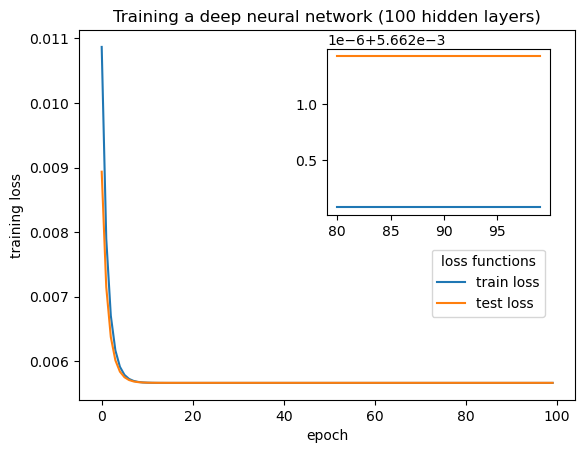

In [ ]:
plot_loss(tracked_loss)

Now we can check the parameter estimates from this regression model. Pytorch
models can have billions or trillions of parameters, so they return the parameters
to the client using a generator. In this model the generator yields back one
vector of parameters at once, but deeper networks (as we will see) can return
more. The generator can either be consumed using a `next` call on the generator
or by using an iterable object to consume the entire generator at once. We will
see the latter in the next section.

In [ ]:
# Use this context manager to ignore gradients whenever you do not want them to
# be part of a computation graph (typical with parameters outside of model training).
with torch.no_grad():
    params = next(linear_regression.parameters()).detach()

# Setting up pretty printing of the parameter comparison. I think there is an
# easier way to do this, but it's not really a common problem to solve. Usually
# you're going to save the parameters somewhere or print them to console without
# formatting.
nn_print = "Neural net estimated params: "
true_params = "True params: "
padding = " " * (len(nn_print) - len(true_params) -1)

# Pretty(ish) print formatting
print(nn_print + f"{params.squeeze()}")
print(true_params + padding + f" {_b}")

Neural net estimated params: tensor([0.8744, 0.3882, 0.2832])
True params:                 tensor([2.0000, 1.0000, 0.5000])


### Deep Networks with Custom Layers

Now we demonstrate a deep network. For this we will build a very deep network
using residual layer connections (He et al., 2016). This idea can be paired with
or used to replace batch normalization (Ioffe and Szegedy, 2015). The details are
not important here, we just want something that will stabilize the parameter
estimation from fitting a very deep network. In this case the model parameters
will not be worth studying, as they will have no meaningful interpretations.

The `fit_model` method we defined earlier can be reused here without modification.

In [ ]:
class ResNetBlock(nn.Module):
    """A simple residual block for use in a deep resnet-like network.

    It is out of scope, but these blocks focus on learning the residual
    representation of the input, which is then added to the input to
    produce the output. This allows the network to learn identity mappings
    and skip connections, which affords learning arbitrarily deep networks
    without vanishing gradients. See [1, 2] for more details on these problems.

    References:

    [1] He et al. (2016). https://arxiv.org/abs/1512.03385

    [2] Ioffe and Christian (2015). https://arxiv.org/abs/1502.03167

    """

    def __init__(self, n_hidden):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
        )

    def forward(self, x):
        return x + self.layers(x)

class DeepResNet(nn.Module):
    """A resnet-like network with several hidden layers.

    The residual part of the network is applied at each hidden layer, allowing
    the network to learn identity mappings and skip connections. This affords
    learning arbitrarily deep networks without the vanishing gradient problem.
    """

    def __init__(self, n_in, n_hidden, n_out, n_layers=5):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_in, n_hidden),      # Input layer
            nn.ReLU(),                      # Input activation function
            nn.BatchNorm1d(n_hidden),       # Batch normalization
            *[nn.Sequential(                # A sequence of Resnet blocks
                ResNetBlock(n_hidden),
                nn.ReLU(),
            ) for _ in range(n_layers)],
            nn.Linear(n_hidden, n_out)      # Output layer
        )

    def forward(self, x):
        return self.layers(x)

With a deep network defined, let's instantiate a copy of it and get to training.
First we'll instantiate the model and print a summary of the layers. Then we'll
train the model and plot the loss, as before.

In [ ]:
deepnet = DeepResNet(3, 10, 1, n_layers=2)

# Print the model architecture
print(deepnet)

DeepResNet(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Sequential(
      (0): ResNetBlock(
        (layers): Sequential(
          (0): Linear(in_features=10, out_features=10, bias=True)
          (1): ReLU()
        )
      )
      (1): ReLU()
    )
    (4): Sequential(
      (0): ResNetBlock(
        (layers): Sequential(
          (0): Linear(in_features=10, out_features=10, bias=True)
          (1): ReLU()
        )
      )
      (1): ReLU()
    )
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [ ]:
tracked_loss = fit_model(train_data, validation_data, deepnet, learn_rate=3e-4, nsteps=100, batch_size=300, generator=gen)

<Axes: title={'center': 'Training a deep neural network (100 hidden layers)'}, xlabel='epoch', ylabel='training loss'>

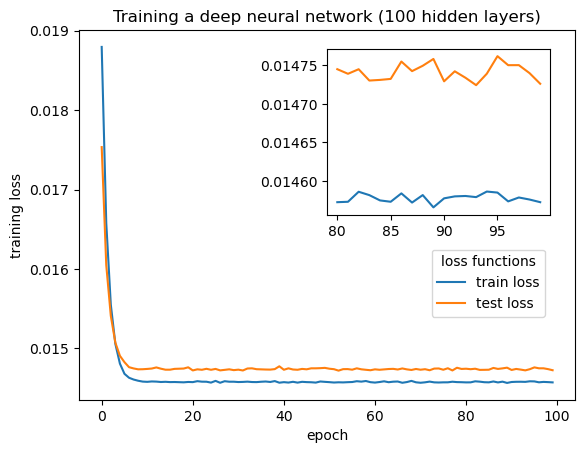

In [ ]:
plot_loss(tracked_loss)

To conclude, let's revisit the last model with a much deeper network. We will
this time use 50 layers to fit the same regression data. This nearly caches the
training data in the parameters, so obviously in practice we'd want to include
test data.

Note: Due to the number of parameters in this model, it is going to initialize
very far away from whatever the "true" parameters are. That will typically cause
the first loss evaluation to be very large. This is not a problem, but the scale
of the loss may surprise you when you view the plot.

In [ ]:
deepnet2 = DeepResNet(3, 10, 1, n_layers=50)

In [ ]:
tracked_loss = fit_model(train_data, validation_data, deepnet2, learn_rate=3e-4, nsteps=100, batch_size=300, generator=gen)

<Axes: title={'center': 'Training a deep neural network (100 hidden layers)'}, xlabel='epoch', ylabel='training loss'>

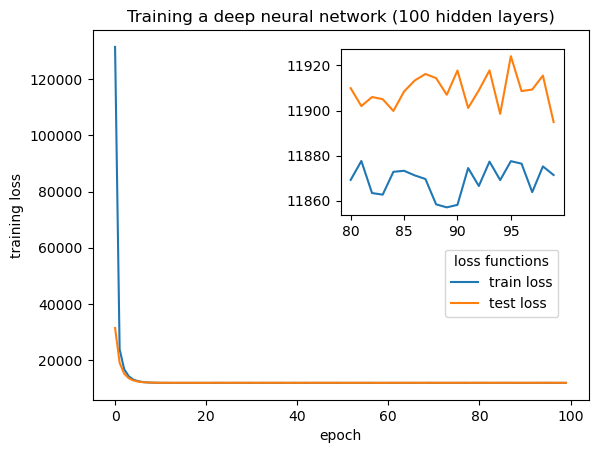

In [ ]:
plot_loss(tracked_loss)

### Model Comparisons

Now in the interest of demonstrating why one would hold back the test data, let's
compare the performance of the three models on the test data. This could be used
as a basis for model averaging or model selection.

In [ ]:
mse_loss = nn.MSELoss()
with torch.no_grad():
    tx, ty = test_data[:]
    lr_test_loss = mse_loss(linear_regression(tx), ty)
    deepnet_test_loss = mse_loss(deepnet(tx), ty)
    deepnet2_test_loss = mse_loss(deepnet2(tx), ty)

print(f"Linear regression test loss: {lr_test_loss}")
print(f"Deep net test loss: {deepnet_test_loss}")
print(f"Deep net 2 test loss: {deepnet2_test_loss}")

Linear regression test loss: 1.761997938156128
Deep net test loss: 4.488327980041504
Deep net 2 test loss: 3578287.75
